<a href="https://colab.research.google.com/github/Pistolll/prak2_TOVII/blob/main/2prakTOVII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Импортируем библиотеки для обработки данных, машинного обучения и нейросетей
import gym
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Загружаем датасет CIC-DDoS2019 с GitHub
url = "https://raw.githubusercontent.com/Pistolll/prak2_TOVII/refs/heads/main/cicddos2019_dataset.csv"
df = pd.read_csv(url)

# Выводим первые строки таблицы
print("Пример данных:")
print(df.head())

# Смотрим уникальные значения метки трафика
print("\nТипы трафика:", df['Label'].unique())


Пример данных:
   Unnamed: 0  Protocol  Flow Duration  Total Fwd Packets  \
0           0        17         216631                  6   
1           1        17              2                  2   
2           2        17             48                  2   
3           3        17         107319                  4   
4           4        17         107271                  4   

   Total Backward Packets  Fwd Packets Length Total  Bwd Packets Length Total  \
0                       0                    2088.0                       0.0   
1                       0                     802.0                       0.0   
2                       0                     766.0                       0.0   
3                       0                    1398.0                       0.0   
4                       0                    1438.0                       0.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  ...  \
0                  393.0                  321.0    

In [3]:
# Заменяем строковые метки: 'Benign' → 0, всё остальное (атаки) → 1
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

# Удаляем пропущенные значения
df = df.dropna()

# Оставляем только числовые столбцы
df = df.select_dtypes(include=[np.number])

# Масштабируем признаки с помощью стандартизации (z-score)
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Label', axis=1))  # признаки
y = df['Label'].values  # метки

In [4]:
# Разбиваем данные: 80% - обучение, 20% - тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Создаём среду обучения на основе интерфейса OpenAI Gym
class TrafficEnv(gym.Env):
    def __init__(self, X, y):
        super(TrafficEnv, self).__init__()
        self.X = X  # входные данные
        self.y = y  # метки
        self.index = 0  # текущий индекс
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)  # действия: 0 = benign, 1 = attack

    def reset(self):
        self.index = 0  # сброс индекса
        return self.X[self.index]

    def step(self, action):
        label = self.y[self.index]  # истинная метка
        reward = 1 if action == label else -1  # +1 за правильную классификацию, -1 за ошибку
        self.index += 1
        done = self.index >= len(self.X)  # проверка конца эпизода
        obs = self.X[self.index] if not done else np.zeros_like(self.X[0])  # следующее наблюдение
        return obs, reward, done, {}


In [6]:
# Простая fully-connected нейросеть для Q-Learning
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # первый слой
            nn.ReLU(),  # активация
            nn.Linear(128, output_dim)  # выходной слой
        )

    def forward(self, x):
        return self.net(x)


In [7]:
# Функция обучения агента на среде
def train_agent(env, episodes=30, gamma=0.99, lr=1e-3, epsilon=0.1):
    """
    Обучает агента с использованием DQN (глубокой Q-сети) в заданной среде.
    Параметры:
    - env: среда (должна соответствовать интерфейсу OpenAI Gym)
    - episodes: количество эпизодов обучения
    - gamma: коэффициент дисконтирования
    - lr: скорость обучения
    - epsilon: вероятность случайного действия (epsilon-greedy)
    Возвращает:
    - обученную модель
    - список суммарных наград по каждому эпизоду
    """
    model = DQN(env.observation_space.shape[0], env.action_space.n)  # инициализируем модель
    optimizer = optim.Adam(model.parameters(), lr=lr)  # оптимизатор Adam
    loss_fn = nn.MSELoss()  # функция потерь — среднеквадратичная ошибка

    rewards_all = []  # список для хранения наград по эпизодам

    for episode in range(episodes):
        obs = torch.FloatTensor(env.reset())  # получаем начальное состояние среды
        total_reward = 0  # суммарная награда за эпизод
        done = False  # флаг завершения эпизода

        while not done:
            # Получаем Q-значения для текущего состояния
            with torch.no_grad():
                q_vals = model(obs)

            # Epsilon-greedy стратегия выбора действия
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # случайное действие
            else:
                action = q_vals.argmax().item()  # действие с максимальным Q

            # Выполняем действие в среде
            next_obs, reward, done, _ = env.step(action)
            next_obs_tensor = torch.FloatTensor(next_obs)

            # Вычисляем целевое значение Q
            with torch.no_grad():
                q_next = model(next_obs_tensor).max().item()
            q_target = reward + gamma * q_next

            # Вычисляем предсказанное Q и обновляем модель
            q_pred = model(obs)[action]
            loss = loss_fn(q_pred, torch.tensor(q_target))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Обновляем состояние и награду
            obs = next_obs_tensor
            total_reward += reward

        rewards_all.append(total_reward)  # сохраняем награду за эпизод
        print(f"Эпизод {episode + 1}/{episodes}, Награда: {total_reward:.2f}")  # выводим прогресс

    return model, rewards_all  # возвращаем обученную модель и список наград

# Создаём среду на основе тренировочных данных
env = TrafficEnv(X_train, y_train)

# Обучаем агента
model, rewards = train_agent(env, episodes=30)




Эпизод 1/30, Награда: 27692.00
Эпизод 2/30, Награда: 30012.00
Эпизод 3/30, Награда: 29670.00
Эпизод 4/30, Награда: 29746.00
Эпизод 5/30, Награда: 30198.00
Эпизод 6/30, Награда: 29920.00
Эпизод 7/30, Награда: 30632.00
Эпизод 8/30, Награда: 30560.00
Эпизод 9/30, Награда: 31130.00
Эпизод 10/30, Награда: 31422.00
Эпизод 11/30, Награда: 31808.00
Эпизод 12/30, Награда: 30804.00
Эпизод 13/30, Награда: 31382.00
Эпизод 14/30, Награда: 31356.00
Эпизод 15/30, Награда: 31726.00
Эпизод 16/30, Награда: 31966.00
Эпизод 17/30, Награда: 32222.00
Эпизод 18/30, Награда: 32422.00
Эпизод 19/30, Награда: 32090.00
Эпизод 20/30, Награда: 32806.00
Эпизод 21/30, Награда: 32848.00
Эпизод 22/30, Награда: 31992.00
Эпизод 23/30, Награда: 32516.00
Эпизод 24/30, Награда: 32826.00
Эпизод 25/30, Награда: 32548.00
Эпизод 26/30, Награда: 32752.00
Эпизод 27/30, Награда: 32668.00
Эпизод 28/30, Награда: 33240.00
Эпизод 29/30, Награда: 32606.00
Эпизод 30/30, Награда: 33300.00


 Награды — это числовые значения, которые агент получает в ходе обучения в каждом эпизоде. Они отражают, насколько хорошо агент справился с задачей на каждом этапе взаимодействия со средой.

Ось X (горизонтальная) — номер эпизода обучения.
Ось Y (вертикальная) — суммарная награда, полученная агентом за один эпизод.
Кривая — показывает, как менялась общая награда по мере обучения агента.


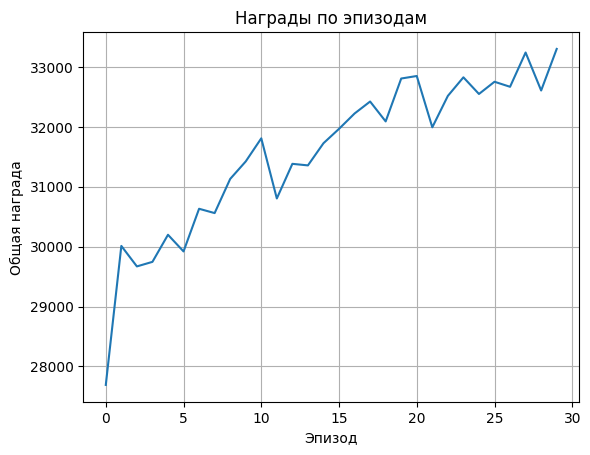

In [8]:
# Строим график наград по эпизодам
plt.plot(rewards)
plt.title("Награды по эпизодам")
plt.xlabel("Эпизод")
plt.ylabel("Общая награда")
plt.grid(True)
plt.show()

Что такое награда в Reinforcement Learning
В обучении с подкреплением:

Агент принимает решения (в нашем случае — классифицирует сетевой трафик как Benign или Attack);

За каждое действие он получает награду:
+1, если правильно классифицировал (например, верно определил атаку);
−1, если ошибся (например, пропустил вредоносный запрос).

Суммарная награда за эпизод — это общее количество очков, набранных агентом при прохождении всей выборки.

In [9]:
# Оцениваем точность классификации RL-модели
def evaluate_model(model, X, y):
    X = torch.FloatTensor(X)  # преобразуем в тензоры
    preds = model(X).argmax(dim=1).numpy()  # получаем предсказания
    from sklearn.metrics import classification_report
    print(classification_report(y, preds, target_names=["Benign", "Attack"]))  # метрики

evaluate_model(model, X_test, y_test)


              precision    recall  f1-score   support

      Benign       1.00      0.85      0.92      1433
      Attack       0.98      1.00      0.99      8281

    accuracy                           0.98      9714
   macro avg       0.99      0.93      0.95      9714
weighted avg       0.98      0.98      0.98      9714



Объяснение метрик:

Precision	Точность — сколько предсказанных Attack действительно были атаками

Recall	Полнота — сколько всех реальных Attack было правильно найдено

F1-score	Среднее между precision и recall

Support	Сколько всего примеров каждого класса в тесте

In [10]:
# Обучаем классическую модель Random Forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

# Выводим метрики качества
print("\n Сравнение с RandomForest:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf, target_names=["Benign", "Attack"]))



 Сравнение с RandomForest:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1433
      Attack       1.00      1.00      1.00      8281

    accuracy                           1.00      9714
   macro avg       1.00      1.00      1.00      9714
weighted avg       1.00      1.00      1.00      9714

